In [ ]:
#for the case where YOLOV4 is not used

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
pip install easyocr

In [ ]:
!pip uninstall opencv-python-headless 
!pip install opencv-python-headless==4.1.2.30

Found existing installation: opencv-python-headless 4.1.2.30
Uninstalling opencv-python-headless-4.1.2.30:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.1.2.30.dist-info/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.7/dist-packages/cv2/.libs/libQtCore-bbdab771.so.4.8.7
    /usr/local/lib/python3.7/dist-packages/cv2/.libs/libQtGui-903938cd.so.4.8.7
    /usr/local/lib/python3.7/dist-packages/cv2/.libs/libQtTest-1183da5d.so.4.8.7
Proceed (y/n)? y
  Successfully uninstalled opencv-python-headless-4.1.2.30
  Using cached opencv_python_headless-4.1.2.30-cp37-cp37m-manylinux1_x86_64.whl (21.8 MB)


In [ ]:
import numpy as np
import cv2
import imutils
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import easyocr
%matplotlib inline

In [ ]:
def preprocessTheImage(img_name):
  #read the image and convert to gray scale
  img = cv2.imread(img_name,cv2.IMREAD_COLOR)
  img = imutils.resize(img, width=500 )
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  cv2_imshow(gray_img)

  #reduce noise - Gaussian filter
  gray_img = cv2.GaussianBlur(gray_img,(5,5),0)
  cv2_imshow(gray_img)

  #Perform Edge detection with Canny
  cannyEdges = cv2.Canny(gray_img, 150, 200) 
  cv2_imshow(cannyEdges)

  return img,cannyEdges

In [ ]:
def extractTheLicense(img,cannyEdges):
  #find contours
  contours,_ = cv2.findContours(cannyEdges.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  img_copy=img.copy()
  cv2.drawContours(img_copy,contours,-1,(0,255,0),3)
  cv2_imshow(img_copy)

  contours = sorted(contours, key = cv2.contourArea, reverse = True)[:30]
 
  img2 = img.copy()
  cv2.drawContours(img2,contours,-1,(0,255,0),3) 
  cv2_imshow(img2) # contours
  new_img=[]
  coord=[]
  for c in contours:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        # print ("approx = ",approx)
        if len(approx) == 4:  # Select the contour that has 4 corners
            LicensePlate = approx 
            x, y, w, h = cv2.boundingRect(c) 
            coord.append((x+w,y+h))
            new_img = img[y:y + h, x:x + w] #Crop the new image
            break

  cv2.drawContours(img, [LicensePlate], -1, (0,255,0), 3)
  cv2_imshow(img)
  return new_img,coord


In [ ]:
def linScale(crop_img):
  if crop_img.ndim==3:
    crop_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
  img = np.double(crop_img)

  min = np.amin(img)
  max = np.amax(img)

  alpha = -1*min
  Gmax = 255
  beta = Gmax/(max-min)
  imLinScaled = (img+alpha)*beta

  imOut = np.uint8(imLinScaled)
  return imOut

# imOut = linScale(imGaussFiltered)
# cv2_imshow(imOut)
# hist = cv2.calcHist([imOut],[0],None,[256],[0,256])
# plt.plot(hist)
# plt.show()

In [ ]:
def thresh(imOut):
  th, im_th = cv2.threshold(imOut, 40, 255, cv2.THRESH_BINARY)
  return im_th
  #cv2_imshow(im_th)

In [ ]:
def erosion(im_th):
  kernel=cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
  #apply erosion to make region clearer
  erodedVersion=cv2.erode(im_th,kernel,iterations=1)
  return erodedVersion
  #cv2_imshow(erodedVersion)

In [ ]:
def convertWhite(imOut):
  h,w=imOut.shape
  img = np.double(imOut)
  imgBinarization=np.zeros((h,w))
  for i in range(h):
    for j in range(w):
      if imOut[i][j]>100:
        imgBinarization[i][j]=0
      else:
        imgBinarization[i][j]=255
  imgBinarization=np.uint8(imgBinarization)
  return imgBinarization

# imgBinarization=convertWhite(imOut)
# cv2_imshow(imgBinarization)

In [ ]:
def dilation(imgBinarization):
  kernel=cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
  #apply dilation to make region clearer
  dilatedVersion=cv2.dilate(imgBinarization,kernel,iterations=1)
  return dilatedVersion
  #cv2_imshow(dilatedVersion)

In [ ]:
def otsu(imOut):
  ret, thresh = cv2.threshold(imOut, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
  cv2_imshow(thresh)
  return thresh

In [ ]:
def histogramApproach(img):									   

    characters = list()
    np_img = np.array(img)

    # calculate the summation for each row and col
    X_summation = cv2.reduce(np_img, 0, cv2.REDUCE_SUM, dtype=cv2.CV_32S)
    Y_summation = cv2.reduce(np_img, 1, cv2.REDUCE_SUM, dtype=cv2.CV_32S)

    # rotate the vector for computations
    X_summation = X_summation.transpose()
    width = img.shape[1]
    height = img.shape[0]

    # calculate the average
    X_sum_avg = X_summation / height
    Y_sum_avg = Y_summation / width

    # convert them to np arrays
    X_temp = np.array(X_sum_avg)
    Y_temp = np.array(Y_sum_avg)

    # convert to zero small details and others 1
    X_temp[X_temp < 20] = 0
    X_temp[X_temp > 20] = 1
    Y_temp[Y_temp < 20] = 0
    Y_temp[Y_temp > 20] = 1


    #store the indices where we go from 0 to 1 and 1 to 0
    
    comp1 = X_temp[0]
    temp1 = list()
    temp2 = list()
    for i in range(X_temp.size):
        if X_temp[i] != comp1:
           
            comp1 = X_temp[i]
            temp1.append(i)
    horizontal = np.array(temp1)

    
    comp2 = Y_temp[0]
    for i in range(Y_temp.size):
        if Y_temp[i] != comp2:
            
            comp2 = Y_temp[i]
            temp2.append(i)
    vertical = np.array(temp2)

    # calculate the height
    rectv = []
    rectv.append(vertical[0])
    rectv.append(vertical[1])
    max = int(vertical[1]) - int(vertical[0])
    for i in range(len(vertical) - 1):
        difference = int(vertical[i + 1]) - int(vertical[i])
        if difference > max:
            rectv[0] = vertical[i]
            rectv[1] = vertical[i + 1]
            max = difference

    #calculate the width and crop it
    for i in range(len(horizontal) - 1):
        diff = int(horizontal[i + 1]) - int(horizontal[i])

        if (diff > 5) and (X_temp[horizontal[i]] == 1):
            characters.append(np_img[int(rectv[0])-5:int(rectv[1])+5, horizontal[i]-5:horizontal[i + 1]+5])
            cv2.rectangle(img, (horizontal[i]-5, rectv[0]-5), (horizontal[i + 1]+5, rectv[1]+5), (0, 255, 0), 1)

    image = plt.imshow(img)
    plt.show(image)

    return characters

In [ ]:
def findCont(processedIm):
  contours, hierarchy = cv2.findContours(processedIm, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  # sort contours
  #contours = sorted(contours, key=cv2.contourArea, reverse=True)

  # loop through contours and find letters in license plate
  selected_contours = []
  for cnt in contours:
      x,y,w,h = cv2.boundingRect(cnt)
      height, width = processedIm.shape
      
      # if height of box is not more than 6 pixels skip
      if height / float(h) > 6: continue
      ratio = h / float(w)
      # if height to width ratio is less than 1.5 skip
      if ratio < 1.5: continue
      # if width is not more than 15 pixels skip
      if width / float(w) > 15: continue
      area = h * w
      # if area is less than 100 pixels skip
      if area < 100: continue
      
      crp = processedIm[y-3:y+h+3, x-3:x+w+3]
      crp = cv2.bitwise_not(crp)
      crp = cv2.medianBlur(crp, 5)
      selected_contours.append(crp)
  selected_contours = selected_contours[::-1]
  return selected_contours


In [ ]:
def isValidChar(txt):
  result=""
  for i in range(len(txt)):
    if (txt[i]==" "):
      result=result+" "
    elif (txt[i].isalnum()):
      result=result+txt[i]
  return result

In [ ]:
def findChar(processedIm):
  try:
    contours = histogramApproach(processedIm)
  except:
    contours = findCont(processedIm)
  reader=easyocr.Reader(['en'],gpu=True)
  plate_num = ""
  # loop through contours and find letters in license plate
  for cnt in contours:
    if (cnt is not None and len(cnt)!=0):
      cv2_imshow(cnt)
      cnt = cv2.resize( cnt, None, fx = 3, fy = 3, interpolation = cv2.INTER_CUBIC)
      cnt= cv2.cvtColor(cnt, cv2.COLOR_GRAY2RGB)
      text=reader.readtext(cnt)
      #text = pytesseract.image_to_string(cnt, config='-c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ --psm 10 --oem 3')
      if (len(text)!=0):
        print(text)
        plate_num += text[0][1].strip()
  #print(plate_num, end=" ")
  if(len(plate_num))<5:
    #cv2_imshow(processedIm)
    text=reader.readtext(processedIm)
    text_easyocr=""
    for res in text:
       text_easyocr=text_easyocr+res[1]+" "
    text_easyocr = isValidChar(text_easyocr)
    return text_easyocr
  else:
   plate_num = isValidChar(plate_num) 
   return plate_num

In [ ]:
def writeOnImage(img, coor, number):
  font = cv2.FONT_HERSHEY_SIMPLEX
    
  # org
  org = (coor[0], coor[1])
    
  # fontScale
  fontScale = 0.75
    
  # Blue color in BGR
  color = (255, 0, 0)
    
  # Line thickness of 2 px
  thickness = 2

  # Using cv2.putText() method
  if(len(number) == 0):
    image = cv2.putText(img, "not found", org, font, 
                    fontScale, color, thickness, cv2.LINE_AA)
  else:
    image = cv2.putText(img, number, org, font, 
                      fontScale, color, thickness, cv2.LINE_AA)
  
  return image

  #cv2_imshow(image)

In [ ]:
def detect(image_path):
  img,cannyEdges=preprocessTheImage(image_path)
  license_cropped,coord=extractTheLicense(img,cannyEdges)

  imOut=linScale(license_cropped)
  thresh=otsu(imOut)
  dilatedVersion=dilation(thresh)
  plate_num=findChar(thresh)
  print(plate_num)
  pred = writeOnImage(img, coord[0], plate_num)
  return pred


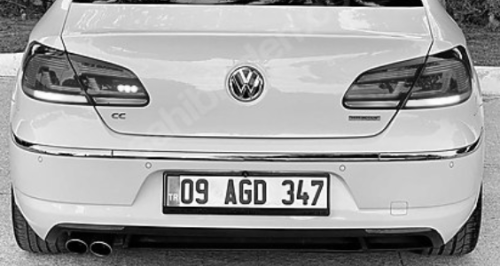

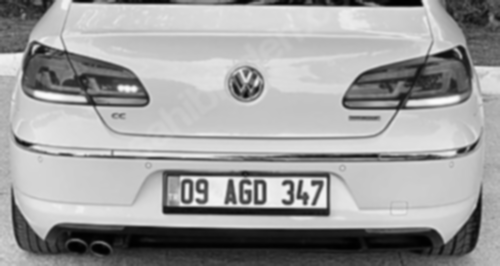

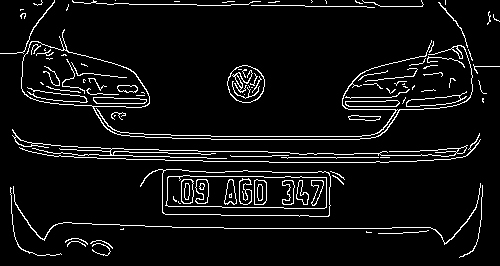

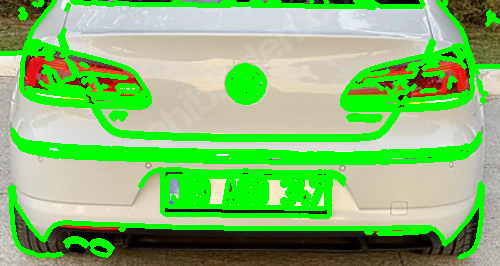

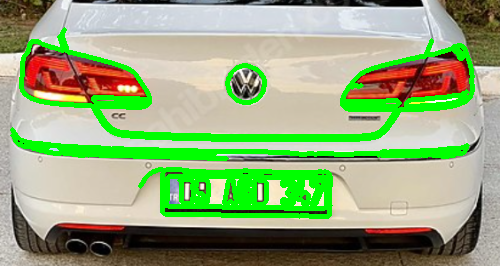

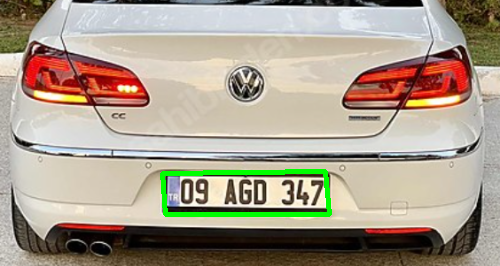

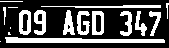

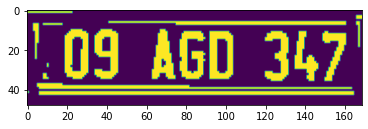

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


1og AGd 347 


In [ ]:
result1=detect("/content/gdrive/MyDrive/EE417/imageswithoutYolo/car6.PNG")

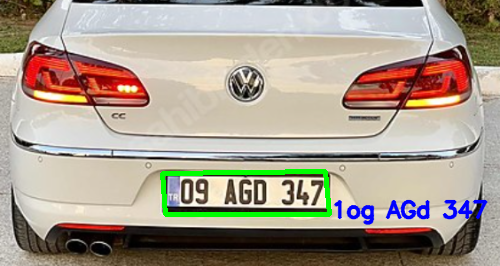

In [ ]:
cv2_imshow(result1)

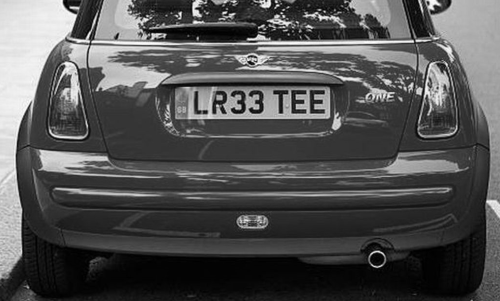

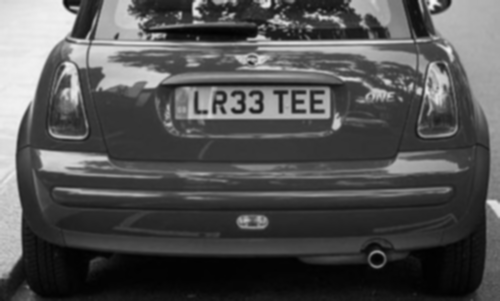

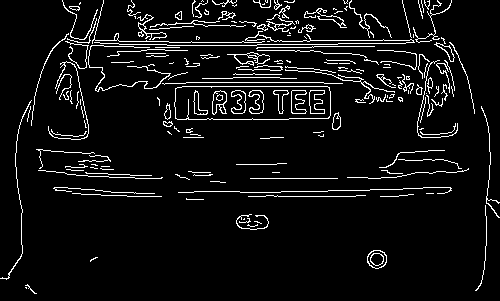

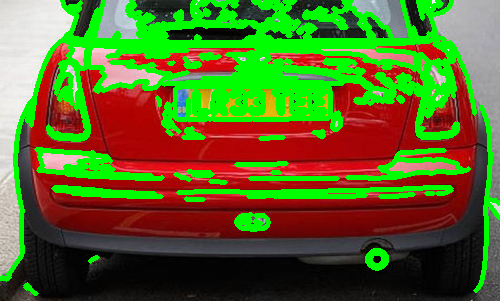

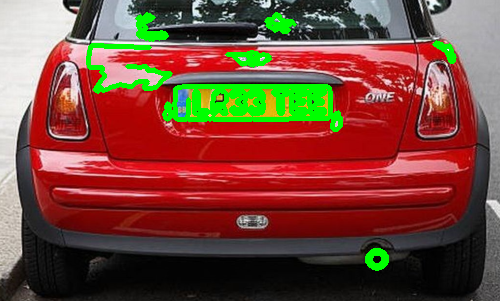

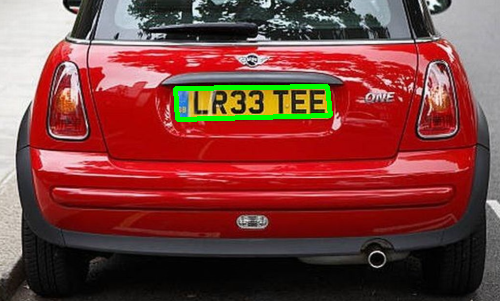

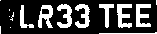

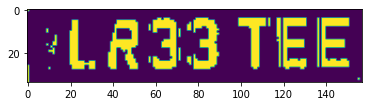

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


LRJJTEE 


In [ ]:
result2=detect("/content/gdrive/MyDrive/EE417/imageswithoutYolo/car1.PNG")

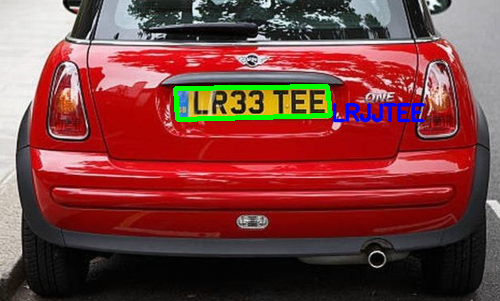

In [ ]:
cv2_imshow(result2)

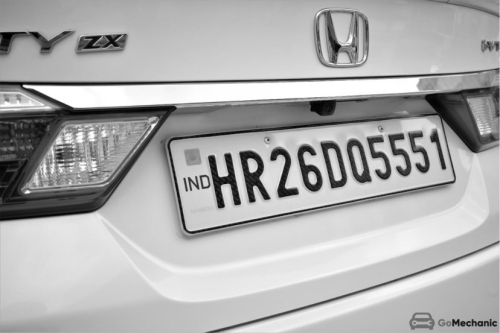

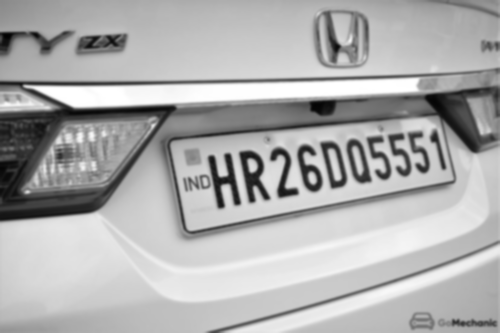

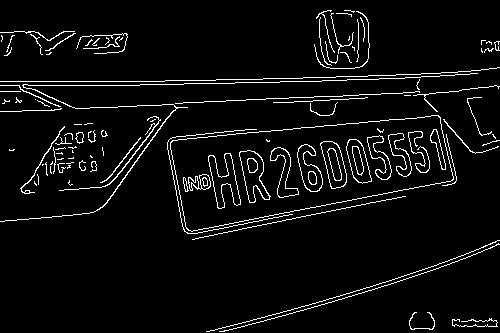

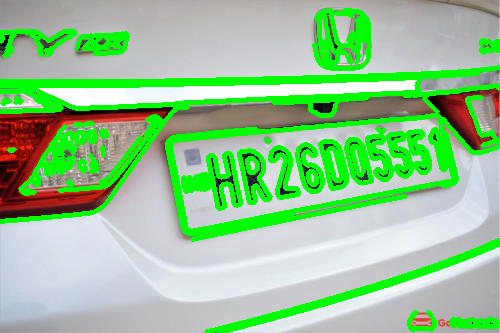

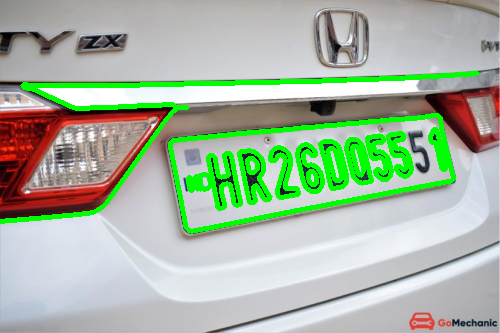

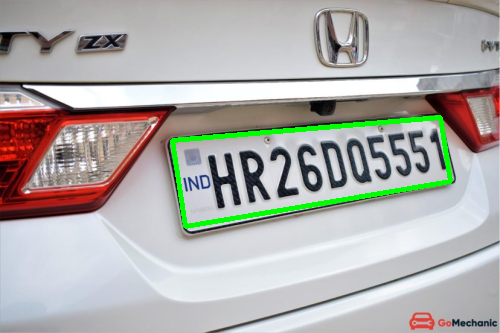

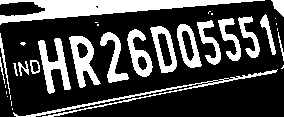

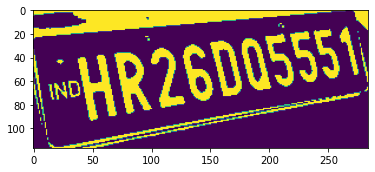

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


wHR26D05551 


In [ ]:
result3=detect("/content/gdrive/MyDrive/EE417/imageswithoutYolo/car9.jpg")

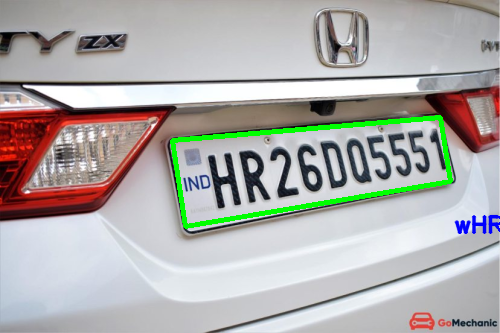

In [ ]:
cv2_imshow(result3)

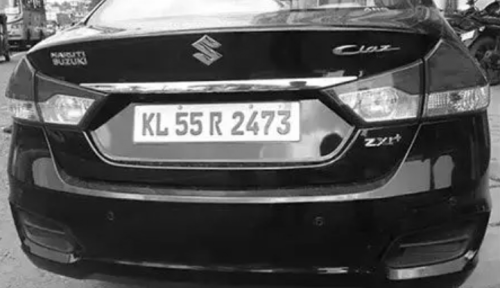

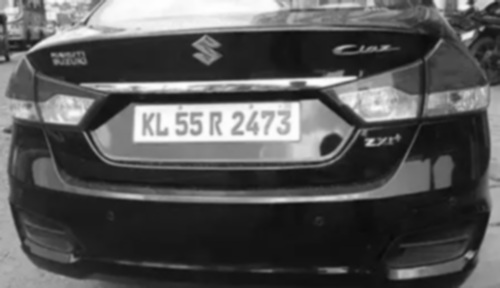

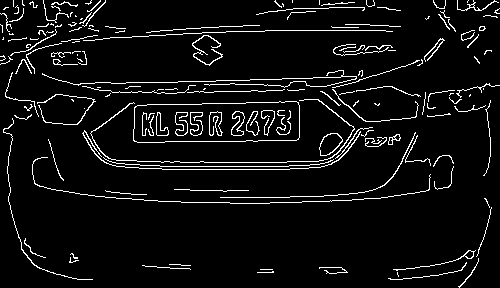

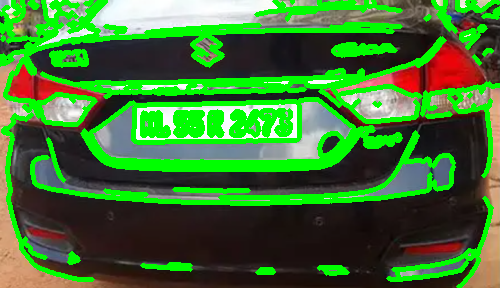

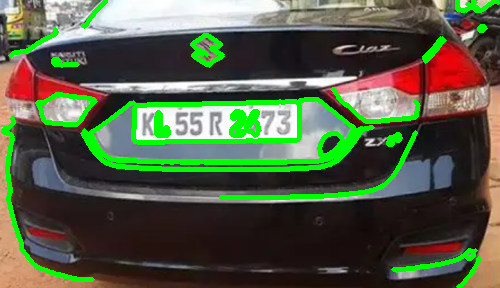

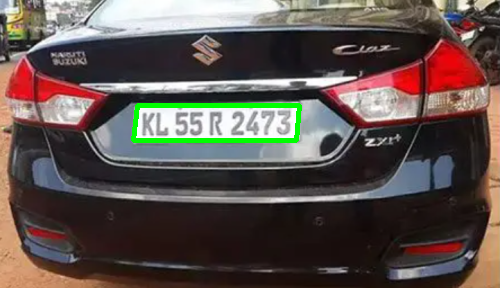

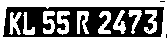

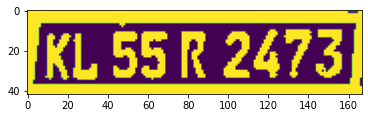

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


KLSSR2473 


In [ ]:
result4=detect("/content/gdrive/MyDrive/EE417/imageswithoutYolo/car3.PNG")

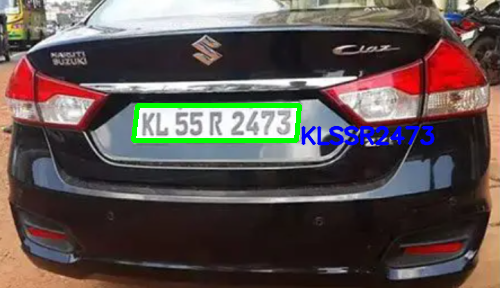

In [ ]:
cv2_imshow(result4)